I am new to this class of Pre-trained models - BERT, ROBERTA, ELMO, etc. I have tried my best to understand and implement things my own way. It's been fun to work on this problem. But, it is hard to hold on to the learning after kaggle so, i am documenting the learnings for as a reference. I hope this notebook will benefit the ones for who are new to this and everything sounds like excellent gibberish. Hopefully,it sheds light on few things for them.

Otherwise too, I was able to get an easy way of implementing models from huggingface with internet off. If you are interested in only this. Please refer to the below link - under kaggle internet off version.

****Actual Colab Notebook with an extended version on how to implement using tfhub too: https://colab.research.google.com/drive/1IubZ3T7gqD09ZIVmJapiB5MXUnVGlzwH#scrollTo=MFMsIbmadulU

***Colab version implementing DistilBert***
https://colab.research.google.com/drive/16QC5JftxtJTR6HiLll9pcnJSmZqc5HhZ

***Kaggle Internet Off Version using Huggingface for Albert/DistilRoberta/Robertalarge***  
https://www.kaggle.com/stitch/albert-huggingface-internet-off-i  
https://www.kaggle.com/stitch/distilroberta-robertalarge-internet-off-i  

Thanks to @returnofsputnik for pointing out huggingface.

Article explaining my understanding BERT and the common issues with using tf2.0:
https://medium.com/@muralim1585/bert-in-keras-tensorflow-2-0-using-tfhub-huggingface-81c08c5f81d8

Please consider upvoting if you find this useful. This notebook to some extent is an adaptation of 
[akensert](https://www.kaggle.com/akensert/bert-base-tf2-0-minimalistic). Plus, [urvishp80](https://www.kaggle.com/urvishp80/quest-encoding-ensemble).  Please consider upvoting that post too. Thanks to @abhishek for figuring how to use transformers offline.

In [ ]:
import sys
sys.path.insert(0, "../input/transformers/transformers-master/")
!pip install ../input/sacremoses/sacremoses-master/ > /dev/null

from transformers import *

import pandas as pd
import numpy as np
import re
from tqdm.notebook import tqdm
from math import floor, ceil

import tensorflow as tf
print(tf.__version__)

In [ ]:
train = pd.read_csv("../input/google-quest-challenge/train.csv")
test = pd.read_csv("../input/google-quest-challenge/test.csv")
sub = pd.read_csv("../input/google-quest-challenge/sample_submission.csv")

1. Go to the github page of huggingface transformers - source - link -https://github.com/huggingface/transformers/tree/master/src/transformers
2. Open the relevant config, modeling or tokenization. In this case, for example it will be configuration_albert.py
3. Under Config_Archive_Map list, you will find aws source its downloading the required files
4. You will require, one config.json, spiece.model (if sentence piece is being used) or vocab.txt/vocab and tf_model.h5 (for keras)
5. Voila ! download file and add it as a dataset to your kernel.
You can use the dataset - https://www.kaggle.com/stitch/albertlargev2huggingface

In [ ]:
albert_path = '../input/albertlargev2huggingface/'
tokenizer = AlbertTokenizer.from_pretrained(albert_path, do_lower_case=True)
albert_model = TFAlbertModel.from_pretrained(albert_path)

#bert_path = '../input/bert-base-uncased-huggingface/'
#tokenizer = BertTokenizer.from_pretrained(bert_path+'vocab.txt', do_lower_case=True)
#bert_model = TFBertModel.from_pretrained(bert_path)

## Preprocessing:  

From a little EDA, it looked like the columns question_title, question_body and answer are the important ones. If I equate it to squad dataset then, question_title is the question, question_body is the context and answer is answer. The average length of title is 30, body is 200 or less and answer is 200 or less. So, the max_sequence_length of 512 works nicely as we can acommodate the above representation very well.

This involves two steps:

- The text contains quite bit of punctuations, intent notes (eg: "read:"), math formulas and new line spaces. This needs to be cleaned. For this I have used : https://www.kaggle.com/urvishp80/quest-encoding-ensemble
- The question and answer needs to be converted into bert tokens. More on this has been briefed in the medium article. The code that has been used though has been broken into functions and for a new person its hard to follow. To make it easy, I had created another version using only list comprehensions in a sequence of generate inputs, masks and segments. But, its not helping performance. So, its better to adopt this function as it is - from BERT Minmalistic. Here is a map of how its connected:  
    -  Trim_inputs is used to make sure that the token counts do not cross the threshold
    - convert_to_* is fairly self explanatory

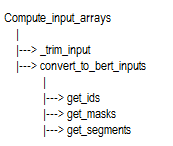

### Text Cleaning:  Click on Expand to see the full cleanup code

In [ ]:
print("Data cleaning started........")
puncts = [',', '.', '"', ':', ')', '(', '-', '!', '?', '|', ';', "'", '$', '&', '/', '[', ']', '>', '%', '=', '#', '*', '+', '\\', '•',  '~', '@', '£',
 '·', '_', '{', '}', '©', '^', '®', '`',  '<', '→', '°', '€', '™', '›',  '♥', '←', '×', '§', '″', '′', 'Â', '█', '½', 'à', '…', '\xa0', '\t',
 '“', '★', '”', '–', '●', 'â', '►', '−', '¢', '²', '¬', '░', '¶', '↑', '±', '¿', '▾', '═', '¦', '║', '―', '¥', '▓', '—', '‹', '─', '\u3000', '\u202f',
 '▒', '：', '¼', '⊕', '▼', '▪', '†', '■', '’', '▀', '¨', '▄', '♫', '☆', 'é', '¯', '♦', '¤', '▲', 'è', '¸', '¾', 'Ã', '⋅', '‘', '∞', '«',
 '∙', '）', '↓', '、', '│', '（', '»', '，', '♪', '╩', '╚', '³', '・', '╦', '╣', '╔', '╗', '▬', '❤', 'ï', 'Ø', '¹', '≤', '‡', '√', ]
mispell_dict = {"aren't" : "are not",
"can't" : "cannot",
"couldn't" : "could not",
"couldnt" : "could not",
"didn't" : "did not",
"doesn't" : "does not",
"doesnt" : "does not",
"don't" : "do not",
"hadn't" : "had not",
"hasn't" : "has not",
"haven't" : "have not",
"havent" : "have not",
"he'd" : "he would",
"he'll" : "he will",
"he's" : "he is",
"i'd" : "I would",
"i'd" : "I had",
"i'll" : "I will",
"i'm" : "I am",
"isn't" : "is not",
"it's" : "it is",
"it'll":"it will",
"i've" : "I have",
"let's" : "let us",
"mightn't" : "might not",
"mustn't" : "must not",
"shan't" : "shall not",
"she'd" : "she would",
"she'll" : "she will",
"she's" : "she is",
"shouldn't" : "should not",
"shouldnt" : "should not",
"that's" : "that is",
"thats" : "that is",
"there's" : "there is",
"theres" : "there is",
"they'd" : "they would",
"they'll" : "they will",
"they're" : "they are",
"theyre":  "they are",
"they've" : "they have",
"we'd" : "we would",
"we're" : "we are",
"weren't" : "were not",
"we've" : "we have",
"what'll" : "what will",
"what're" : "what are",
"what's" : "what is",
"what've" : "what have",
"where's" : "where is",
"who'd" : "who would",
"who'll" : "who will",
"who're" : "who are",
"who's" : "who is",
"who've" : "who have",
"won't" : "will not",
"wouldn't" : "would not",
"you'd" : "you would",
"you'll" : "you will",
"you're" : "you are",
"you've" : "you have",
"'re": " are",
"wasn't": "was not",
"we'll":" will",
"didn't": "did not",
"tryin'":"trying"}


def clean_text(text):
    text = re.sub(r"[^A-Za-z0-9^,!.\/'+-=]", " ", text)
    #text = text.lower().split()
    #stops = set(stopwords.words("english"))
    #text = [w for w in text if not w in stops]    
    #text = " ".join(text)
    return(text)

def _get_mispell(mispell_dict):
    mispell_re = re.compile('(%s)' % '|'.join(mispell_dict.keys()))
    return mispell_dict, mispell_re

def replace_typical_misspell(text):
    mispellings, mispellings_re = _get_mispell(mispell_dict)

    def replace(match):
        return mispellings[match.group(0)]

    return mispellings_re.sub(replace, text)

def clean_data(df, columns: list):
    for col in columns:
        df[col] = df[col].apply(lambda x: clean_text(x.lower()))
        df[col] = df[col].apply(lambda x: replace_typical_misspell(x))

    return df

In [ ]:
columns = ['question_title','question_body','answer']
train= clean_data(train, columns)
test = clean_data(test, columns)
print("Data cleaning Done........")

### Convert text into Bert required format of input_ids, masks, segments

In [ ]:
def _get_segments(tokens,_maxlen):
    sentences_segments = []
    i=0
    for token in tokens:
        sentences_segments.append(i)
        if token == "[SEP]":
            i += 1
    return sentences_segments + [0] * (_maxlen - len(tokens))

def _get_inputs(df,_maxlen,tokenizer,use_keras_pad=False):
    
    #generate input ids  
    maxqnans = np.int((_maxlen-34)/2) #approx token size : qn = 230, ans = 230, title =30, special_words = 4
    pattern = '[^\w\s]+|\n' # remove everything including newline (|\n) other than words (\w) or spaces (\s)
    
    sentences = [["[CLS] "] + tokenizer.tokenize(title)[:20]+ ["[SEP]"]
                  + tokenizer.tokenize(qn)[:maxqnans] + ["[SEP]"]
                  + tokenizer.tokenize(ans)[:maxqnans] + ["[SEP]"]
                  for (title,qn,ans) 
                in 
              zip(df['question_title'].str.replace(pattern, '').values.tolist(),
              df['question_body'].str.replace(pattern, '').values.tolist(),
              df['answer'].str.replace(pattern, '').values.tolist())]
    
    
    # if less than max length provided then the words are padded
    if use_keras_pad:
        sentences_padded = pad_sequences(sentences, dtype=object, maxlen=_maxlen, value=['[PAD]'],padding='post')
    else:
        sentences_padded = [tokens + ["[PAD]"]*(_maxlen-len(tokens)) if len(tokens)!=_maxlen else tokens for tokens in sentences ]

    sentences_converted = [tokenizer.convert_tokens_to_ids(s) for s in sentences_padded]
    
    
    #generate masks
    # bert requires a mask for the words which are padded. 
    # Say for example, maxlen is 100, sentence size is 90. then, [1]*90 + [0]*[100-90]
    sentences_mask = [[1]*len(tokens)+[0]*(_maxlen - len(tokens)) for tokens in sentences]
 
    
    #generate segments
    # for each separation [SEP], a new segment is converted
    sentences_segments = [_get_segments(tokens,_maxlen=_maxlen) for tokens in sentences]

    genLength = set([len(tokens) for tokens in sentences_padded])
    if _maxlen < 20:
        raise Exception("max length cannot be less than 20")
    elif len(genLength)!=1: 
        print(genLength)
        raise Exception("sentences are not of same size \n {}".format(genLength))

    #convert list into tensor integer arrays and return it
    #return sentences_converted,sentences_segment, sentences_mask
    #return sentences
    return [np.asarray(sentences_converted, dtype=np.int32), 
            np.asarray(sentences_mask, dtype=np.int32), 
            np.asarray(sentences_segments, dtype=np.int32)]
    #return [tf.cast(sentences_converted,tf.int32), tf.cast(sentences_segment,tf.int32), tf.cast(sentences_mask,tf.int32)]

In [ ]:
MAX_SEQUENCE_LENGTH = 512
Xtr = _get_inputs(train,_maxlen=MAX_SEQUENCE_LENGTH,tokenizer=tokenizer,use_keras_pad=False)
ytr = np.asarray(train.iloc[:,11:])

In [ ]:
Xte = _get_inputs(test,_maxlen=MAX_SEQUENCE_LENGTH,tokenizer=tokenizer,use_keras_pad=False)

## Create train and test data

## Add Pre-trained model using Transformer
Much has been said about these pretrained models but, the important concepts around transfer learning meaning,  how we can use it required some bit of digging. For example, if you had used tfhub version of bert. One might wonder, what its the "trainable" in the layer?

It turns out there are three ways that we can do transfer learning of Pretrained models:  
- Feature Extraction : where the pretrained layer is used to only extract features like using batchnormalization to convert the weights into a range between 0 to 1 with mean being 0. In this method, the weights are not updated during back propagation. This what is marked as non-trainable in the model summary and in tfhub as trainable=False. If you would like to set it manually. then, you select the layer like this: model.add(dense(100, trainable=False)) 
- Fine Tuning: Sort of what this entire competition is about. BERT is ideal for this task because it trained for question answering. So, we just have to fine tune the model to suit our purpose. What it means - the layer has been trained for a general dataset. we need to retrain to optimize for our specific task. This again, in TFHUB is trainable = True. In Keras Model Summary, its called out as trainable parameters. Usually this is huge. Albert which is the light version contains 11 million parameters. 
- Extract Layers: this is another way where in we extract only those layers required for task for example, we might extract just the lower levels layers in BERT to carry out tasks like POS, sentiment analysis, etc where only extracting word level features would be enough and too much of context or sequence matching is not required.

***Important Note***  
Given the crazy about of parameters amount to be tuned in less than 2 hrs + the BERT paper recommendation is adopt:  
- Epochs - range between 3,4  
- Batch_size - 4,8,16 (if you training for specific groups like stackoverflow then might be 32)  
- Layers - You may not have add any additional layers apart from the output & averaging one. Since BERT or equivalent has already has optimized the layres & hidden units for us. I did try adding adding a layer for vanishing gradients - these deep belief networks can dwindle the weights to almost zero so, i had added a leaky relu layer to slow weight deterioration. The model run time went up crazily.  
- Custom_Callback (from BERT minimalistic)- beware that this function is doing model.predict on validation and test data for each epoch which, will considerably slow down your model completion. although its nice to see the score improvement at each epoch. My suggestion is try to calculate at the end of every fold and not epoch.  

To avoid overfitting and promote generalization - Implementing KFold Validation & Early Stopping & Dropout & L2 Regualizer (Ridge: pushes weights closer to zero not zero)

I am not going expand on the concepts here but, will write a separate article and share the link at later point

In [ ]:
from tensorflow.keras.layers import Dense, Dropout,Embedding, LSTM, Bidirectional, Input, Dropout, GlobalAveragePooling1D
from tensorflow.keras import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers
import tensorflow.keras.backend as K

from sklearn.model_selection import KFold, GroupKFold
from scipy.stats import spearmanr

import warnings; warnings.simplefilter('ignore')

In [ ]:
def build_model():
    
    token_inputs = Input((MAX_SEQUENCE_LENGTH), dtype=tf.int32, name='input_word_ids')
    #mask_inputs = Input((MAX_SEQUENCE_LENGTH,), dtype=tf.int32, name='input_masks')
    #seg_inputs = Input((MAX_SEQUENCE_LENGTH,), dtype=tf.int32, name='input_segments')

    # going with pooled output since seq_output results in ResourceExhausted Error even with GPU
    _,pooled_output = albert_model(token_inputs)#[token_inputs, mask_inputs, seg_inputs])
    #X = GlobalAveragePooling1D()(pooled_output)
    X = Dropout(0.2)(pooled_output)
    output_= Dense(30, activation='sigmoid', name='output')(X)

    #bert_model2 = Model([token_inputs, mask_inputs, seg_inputs],output_)
    bert_model2 = Model(token_inputs,output_)
    
    print(bert_model2.summary())
    
    bert_model2.compile(optimizer= Adam(learning_rate=0.0001), loss='binary_crossentropy')
    
    return bert_model2

## Leave One Out Validation - about 20% of data

Xtr_holdout = [arr[:4800] for arr in Xtr]
ytr_holdout = ytr[:4800]
Xtr_val = [arr[1200:] for arr in Xtr]
ytr_val = ytr[1200:]

print(Xtr_holdout[1].shape," ", ytr_holdout.shape)

model = build_model(
es = EarlyStopping(monitor='val_loss', min_delta=0, patience=1, verbose=0, mode='auto', baseline=None, restore_best_weights=True)
model.fit(Xtr_holdout,ytr_holdout,epochs=5,batch_size = 8,validation_split = 0.2,callbacks=[es])
    
pred_ = pd.DataFrame(model.predict(Xtr_val,batch_size=8))
val_ = pd.DataFrame(ytr_val)
spearman_score = np.nanmean([spearmanr(pred_.iloc[:,i].values,val_.iloc[:,i].values).correlation for i in np.arange(len(pred_.columns))])
print(spearman_score)

# KFold & Group Fold Validation

In [ ]:
i=0
num_folds = 3
#kfold = KFold(n_splits=num_folds, shuffle=True, random_state=1)
gkf = GroupKFold(n_splits=3).split(X=train.question_body, groups=train.question_body)
fold_score = []
#test_preds = np.zeros((Xte[0].shape[0],ytr.shape[1])) # mimic rows shape of test data, columns shape from train since, test will have any column for outputs
test_preds = []

#for train_index,val_index in kfold.split(ytr):
for fold, (train_index, val_index) in enumerate(gkf):

    i= i+1
    print('executing fold no: {}'.format(i))
    
    K.clear_session()
    # train_index gets a random sample of rows for training
    # Xtr is a list contains 3 np arrays - ids, masks, segments so, using list comprehension to get the splits
    Xtr_fold = [arr[train_index] for arr in Xtr]
    ytr_fold = ytr[train_index]
    
    Xtr_val = [arr[val_index] for arr in Xtr]
    ytr_val = ytr[val_index]
    
    model = build_model()
    es = EarlyStopping(monitor='val_loss', min_delta=0, patience=1, verbose=0, mode='auto', baseline=None, restore_best_weights=True)
    #model.fit(Xtr_fold,ytr_fold,epochs=5,batch_size = 8,validation_data = (Xtr_val,ytr_val),callbacks=[es])
    model.fit(Xtr_fold[0],ytr_fold,epochs=5,batch_size = 4 ,validation_split = 0.2,callbacks=[es])
    
    #calculate spearman score
    pred_ = pd.DataFrame(model.predict(Xtr_val[0]))
    val_ = pd.DataFrame(ytr_val)
    spearman_score = np.nanmean([spearmanr(pred_.iloc[:,i].values,val_.iloc[:,i].values).correlation for i in np.arange(len(pred_.columns))])
    print("Spearman Score on validation data : {}".format(spearman_score))
    fold_score.append(spearman_score)
    test_preds.append(model.predict(Xte))

print("Spearman Score on validation data : {}".format(np.mean(fold_score)))


In [ ]:
#average of across arrays by row
sub.iloc[:, 1:] = np.average(test_preds,axis=0)
sub.to_csv('submission.csv', index=False)